In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade pip setuptools wheel
# !{sys.executable} -m pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [5]:
# import sys, pkgutil, importlib, site
# print("Python executable:", sys.executable)
# print("Python version:", sys.version.splitlines()[0])
# print("First sys.path entries:", sys.path[:6])

# # what chronos-like modules are visible to this interpreter?
# print([m.name for m in pkgutil.iter_modules() if 'chronos' in m.name.lower()])
# print("find_spec('chronos') ->", importlib.util.find_spec('chronos'))
# print("find_spec('chronos_forecasting') ->", importlib.util.find_spec('chronos_forecasting'))

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

# Import custom modules
import sys
sys.path.append("../src")
from visualization.plots import EnergyForecastVisualizer
from data.data_loader import DataLoader
from data.chronos_preprocessor import ChronosPreprocessor  # Changed from prophet_preprocessor
from evaluation.metrics import ForecastMetrics

print("Custom modules imported successfully!")

# Load configuration
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Add Chronos-specific config if not present
if 'chronos' not in config:
    config['chronos'] = {
        'model_name': 'amazon/chronos-t5-small'  # or 'amazon/chronos-t5-base' for better performance
    }

print("Configuration loaded:")
print(f"Target variable: {config['target']['column']}")
print(f"Chronos model: {config['chronos']['model_name']}")

Libraries imported successfully!
Custom modules imported successfully!
Configuration loaded:
Target variable: total_load_actual
Chronos model: amazon/chronos-t5-small


### Load data and merge

In [8]:
# Load energy dataset (same as Prophet)
loader = DataLoader(config)
df_energy = loader.load_energy_data()

# Load weather dataset (for analysis only, Chronos doesn't use external regressors)
# df_weather = loader.load_weather_data()

# Add temporal features to energy data
df_energy = loader.create_temporal_features(df_energy)

# Merge energy and weather data (for exploratory analysis)
# merged_df = df_energy

print("Data loaded and merged successfully!")
print(f"Energy dataset shape: {df_energy.shape}")

Loading energy dataset...
Missing values in target variable: 0
Energy data shape after cleaning: (1461, 1)
Date range: 2015-01-01 00:00:00 to 2018-12-31 00:00:00
Creating temporal features...
Temporal features created.
Data loaded and merged successfully!
Energy dataset shape: (1461, 4)


Generating time series overview...


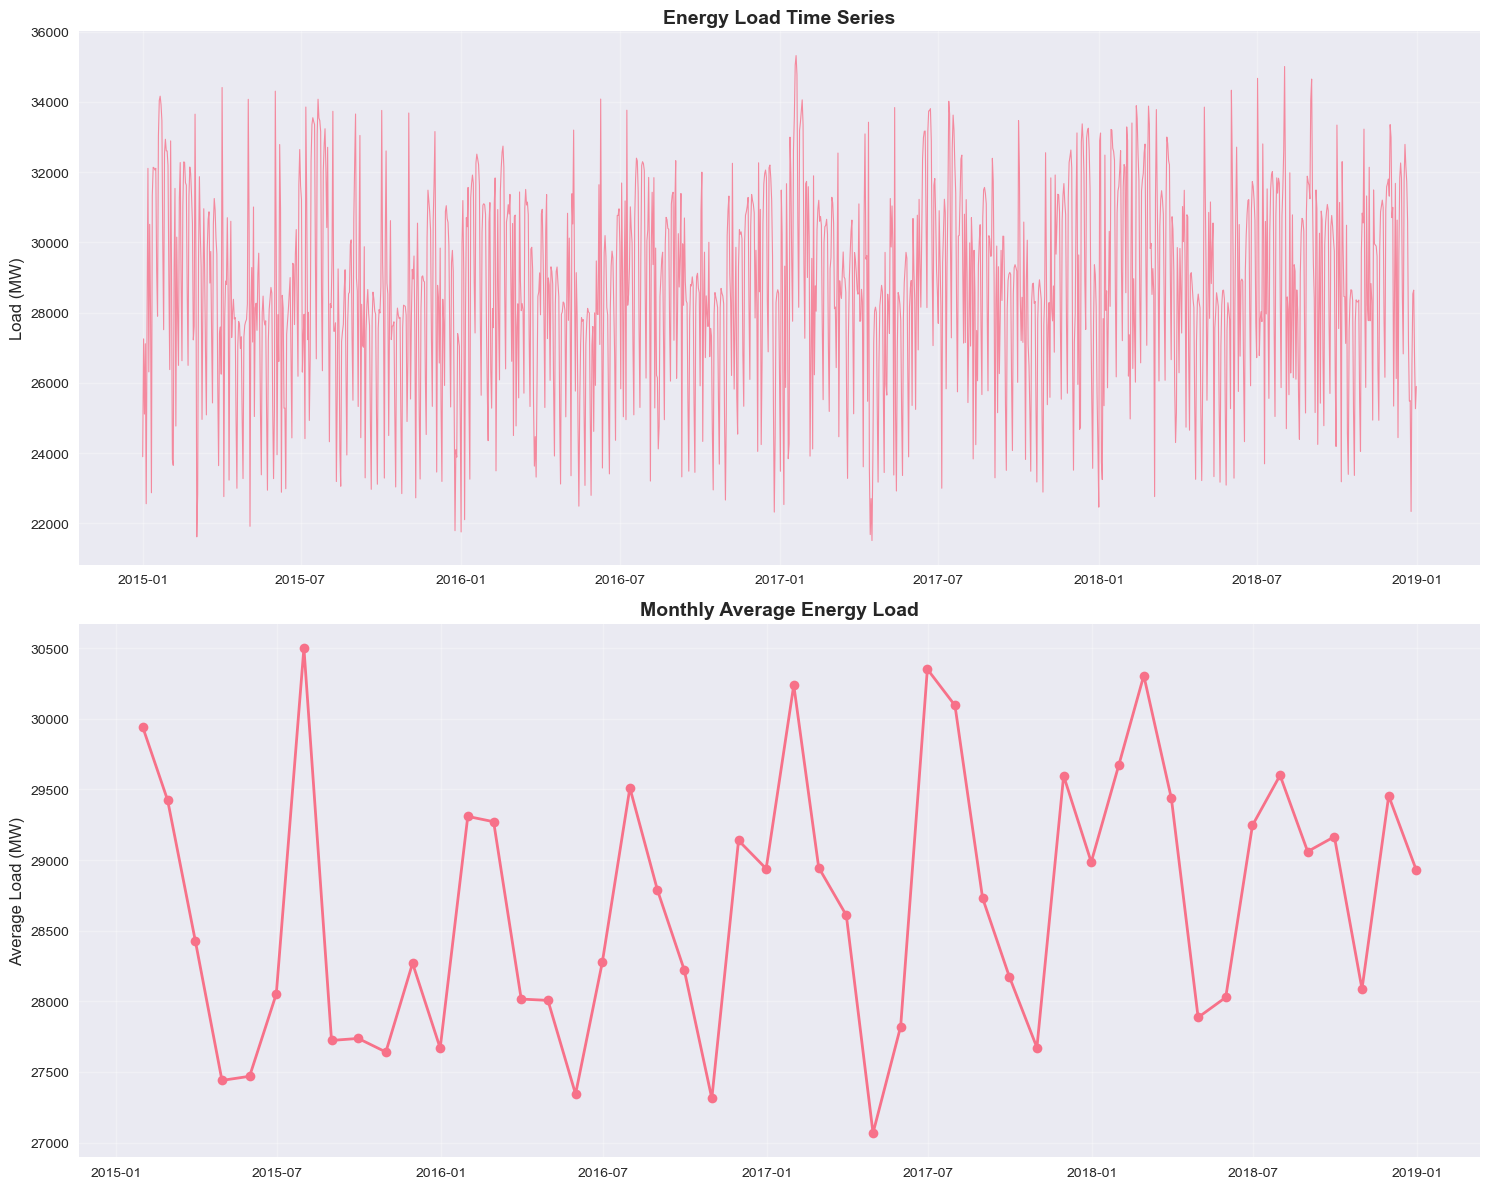

Dataset Statistics:

Target Variable (total_load_actual):
  Mean: 28696.20 MW
  Std:  2758.72 MW
  Min:  21511.00 MW
  Max:  35315.00 MW


In [9]:
# Initialize visualizer (same as Prophet)
visualizer = EnergyForecastVisualizer(figsize=(15, 8))

# Time series overview (same as Prophet)
print("Generating time series overview...")
fig1 = visualizer.plot_time_series_overview(df_energy, config['target']['column'])
plt.show()

# Basic statistics (same as Prophet)
print("Dataset Statistics:")
target_col = config['target']['column']
print(f"\nTarget Variable ({target_col}):")
print(f"  Mean: {df_energy[target_col].mean():.2f} MW")
print(f"  Std:  {df_energy[target_col].std():.2f} MW")
print(f"  Min:  {df_energy[target_col].min():.2f} MW")
print(f"  Max:  {df_energy[target_col].max():.2f} MW")

In [10]:
# Preprocess data for Chronos (simplified preprocessing)
print("Preprocessing data for Chronos...")
preprocessor = ChronosPreprocessor(config)  # Changed from ProphetPreprocessor
train_df, test_df = preprocessor.prepare_data_for_chronos(df_energy)  # Changed method name

print(f"Preprocessed data shapes:")
print(f"  Training set: {train_df.shape}")
print(f"  Test set: {test_df.shape}")

print(f"Data splits:")
print(f"  Train period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"  Test period: {test_df['ds'].min()} to {test_df['ds'].max()}")

# Display sample of preprocessed data
print("Sample of preprocessed training data:")
print(train_df.head())

print("\nNote: Chronos is a univariate model - only uses the target time series")

Preprocessing data for Chronos...
Starting Chronos preprocessing pipeline...
Train and Test splitting started...
Train set: 1168 samples (2015-01-01 00:00:00 to 2018-03-13 00:00:00)
Test set: 293 samples (2018-03-14 00:00:00 to 2018-12-31 00:00:00)
Train and Test splitting completed successfully!
Chronos dataframe created with shape: (1168, 2)
Note: Chronos uses univariate time series (only 'y' values)
Chronos dataframe created with shape: (293, 2)
Note: Chronos uses univariate time series (only 'y' values)
Chronos preprocessing completed successfully!
Train data: 1168 samples
Test data: 293 samples
Preprocessed data shapes:
  Training set: (1168, 2)
  Test set: (293, 2)
Data splits:
  Train period: 2015-01-01 00:00:00 to 2018-03-13 00:00:00
  Test period: 2018-03-14 00:00:00 to 2018-12-31 00:00:00
Sample of preprocessed training data:
          ds        y
0 2015-01-01  23897.0
1 2015-01-02  27251.0
2 2015-01-03  25111.0
3 2015-01-04  27113.0
4 2015-01-05  22559.0

Note: Chronos is a 

In [11]:
# Initialize and train Chronos model
print("Initializing Chronos model...")
from models.chronos_model import EnergyChronosModel
chronos_model = EnergyChronosModel(config)  # Changed from EnergyProphetModel
model = chronos_model.fit_baseline_model(train_df)  # Same method name for compatibility
print("Chronos model initialized successfully!")

# Generate predictions
print("Generating Chronos predictions...")
forecast = chronos_model.predict(test_df)  # Same method name

print(f"\nForecast shape: {forecast.shape}")
print("\nSample forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

Initializing Chronos model...
Initializing Chronos model: amazon/chronos-t5-small


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Preparing Chronos baseline model...
Chronos model prepared successfully!
Chronos model initialized successfully!
Generating Chronos predictions...
Generating Chronos predictions...
Forecast generated for 293 periods

Forecast shape: (293, 4)

Sample forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2018-03-14  31645.646484  27185.513672  33355.356836
1 2018-03-15  31433.246094  25242.162207  33355.356836
2 2018-03-16  30583.699219  24626.253027  33132.339844
3 2018-03-17  29097.005859  25465.181250  32930.583594
4 2018-03-18  27928.859375  23766.089453  32707.564453


In [12]:
# Calculate evaluation metrics (same as Prophet)
print("Calculating evaluation metrics...")
metrics_calc = ForecastMetrics()

y_true = test_df['y'].values
y_pred = forecast['yhat'].values

chronos_metrics = metrics_calc.calculate_all_metrics(y_true, y_pred)
metrics_calc.print_metrics_summary(chronos_metrics, "Chronos Model")

# Create detailed metrics DataFrame (same as Prophet)
metrics_df = pd.DataFrame({
    'Metric': list(chronos_metrics.keys()),
    'Value': list(chronos_metrics.values())
})

# Format for better display
metrics_df['Formatted_Value'] = metrics_df.apply(lambda x: 
    f"{x['Value']:.2f} MW" if x['Metric'] in ['MAE', 'RMSE'] 
    else f"{x['Value']:.4f}", axis=1)

print(metrics_df[['Metric', 'Formatted_Value']])

Calculating evaluation metrics...

Chronos Model Performance Metrics
MAE                 :  2162.99 MW
RMSE                :  2626.75 MW
MAPE                :     7.67%
SMAPE               :     7.56%
R2                  :     0.01%
Directional_Accuracy:    16.10%
                 Metric Formatted_Value
0                   MAE      2162.99 MW
1                  RMSE      2626.75 MW
2                  MAPE          7.6698
3                 SMAPE          7.5642
4                    R2          0.0072
5  Directional_Accuracy         16.0959


Generating Chronos forecast visualization...


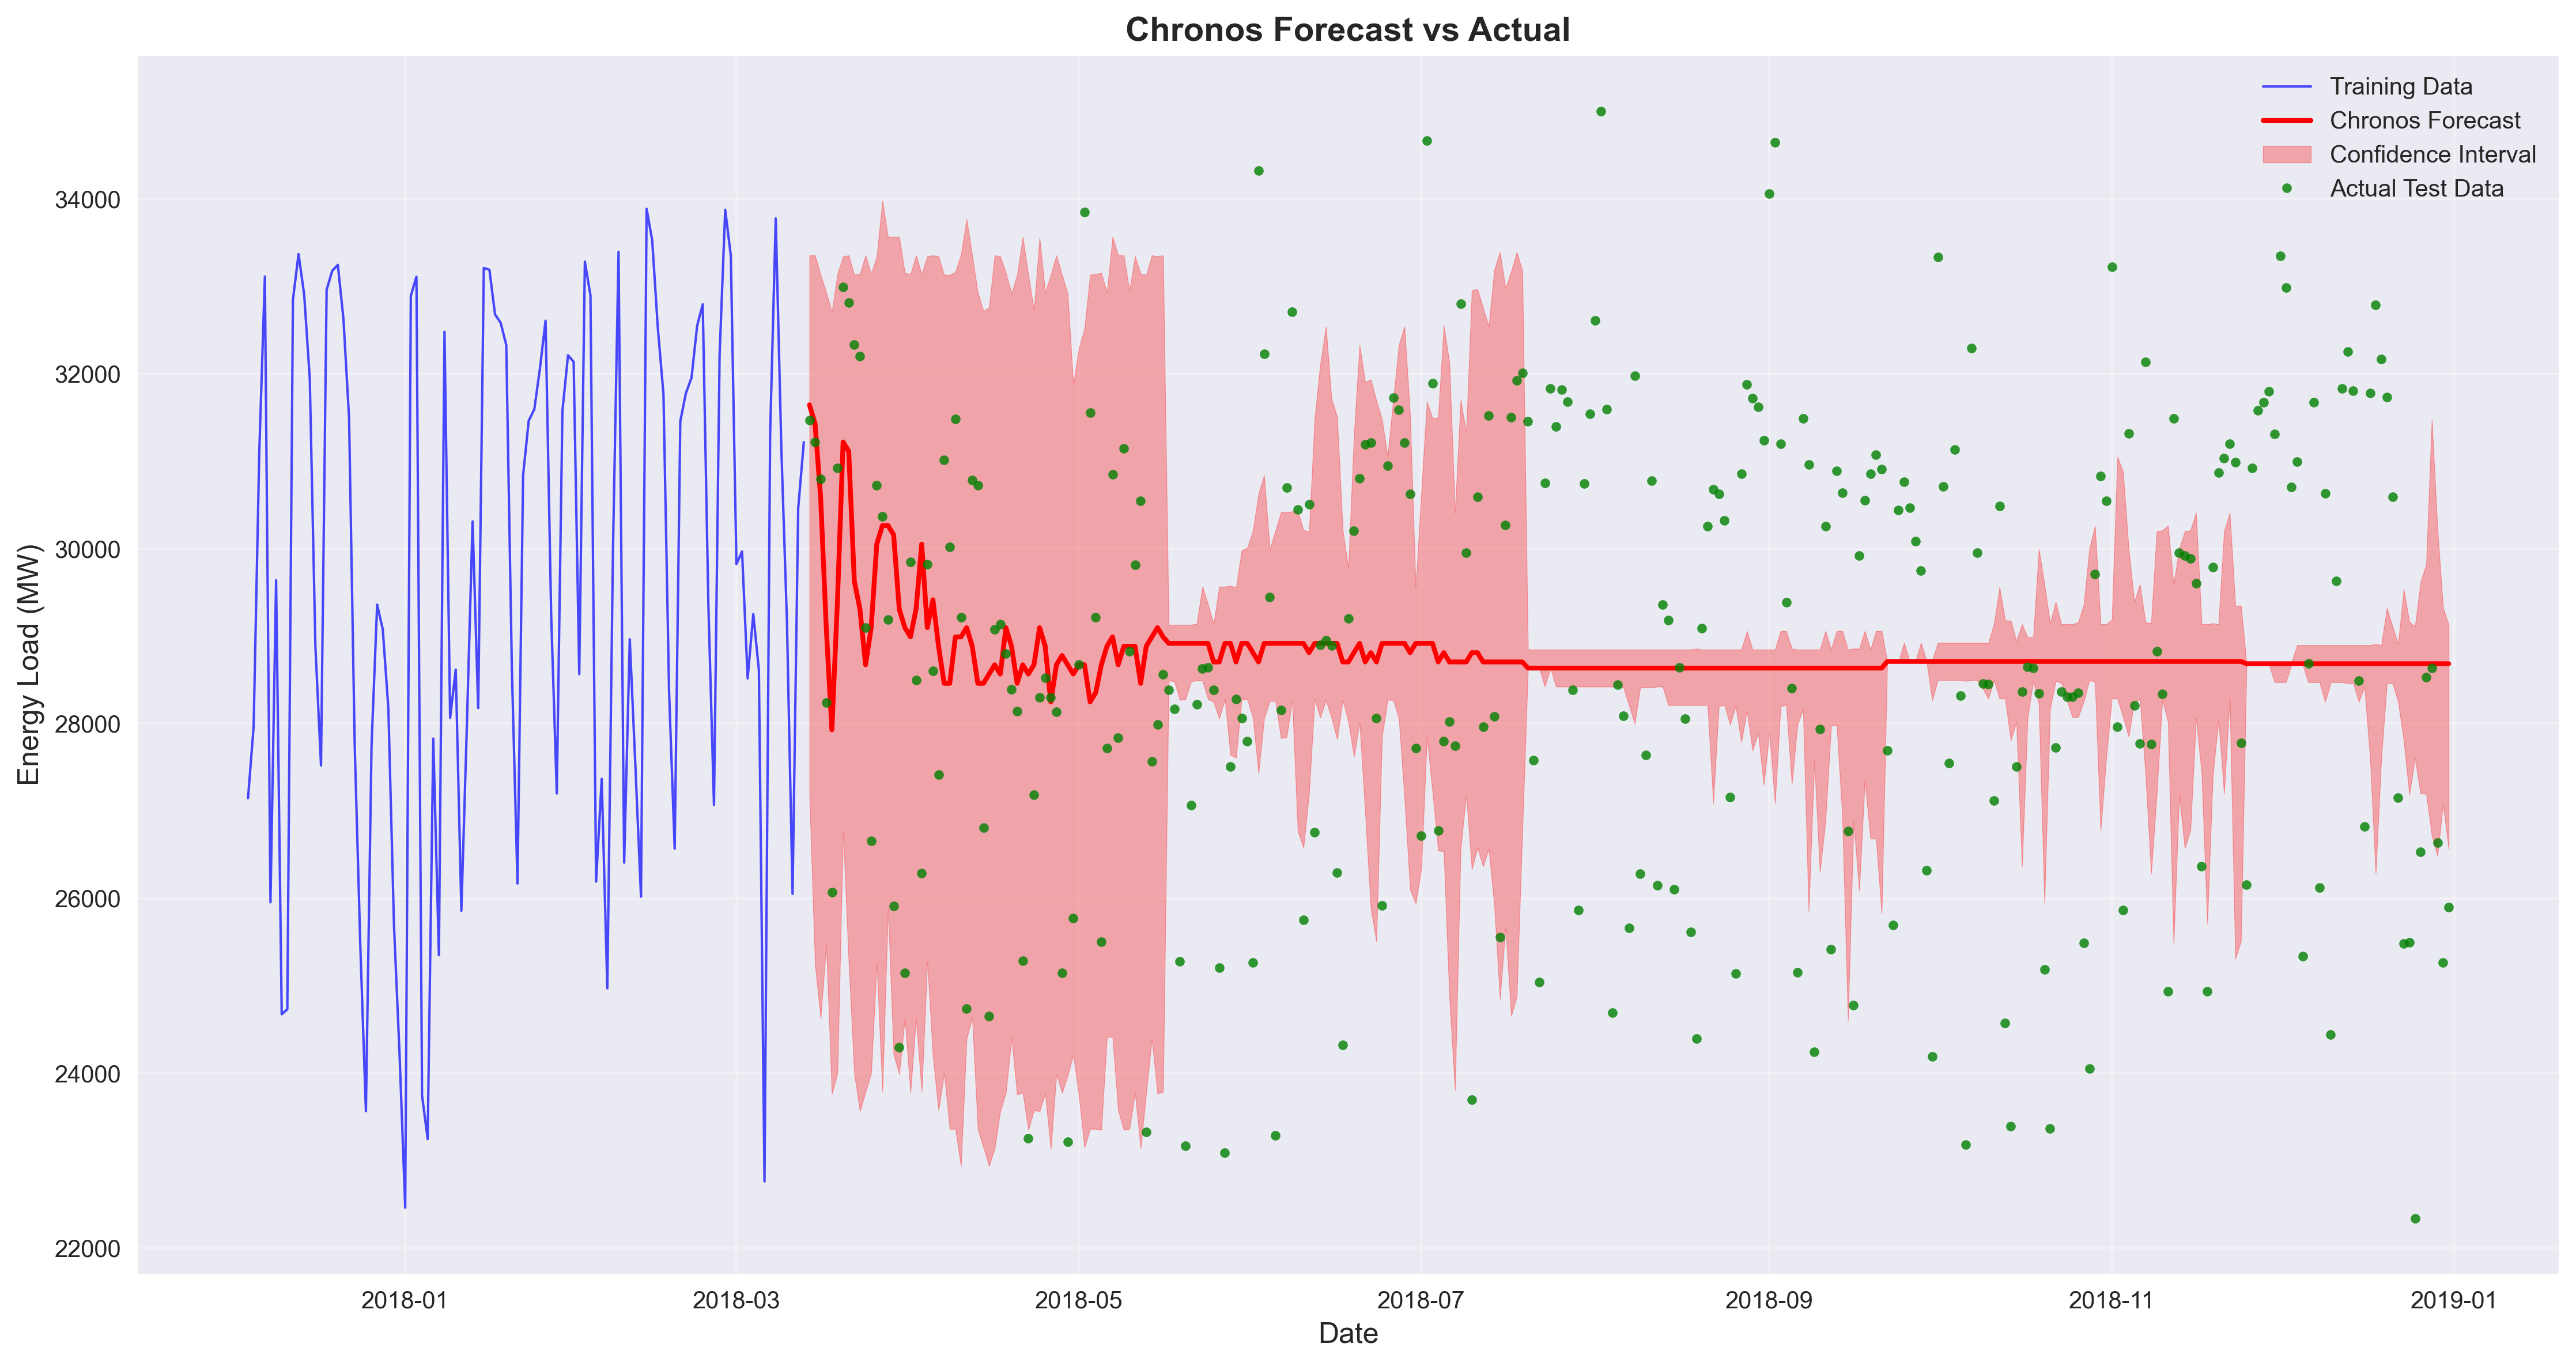

Comparing forecast vs actual values...


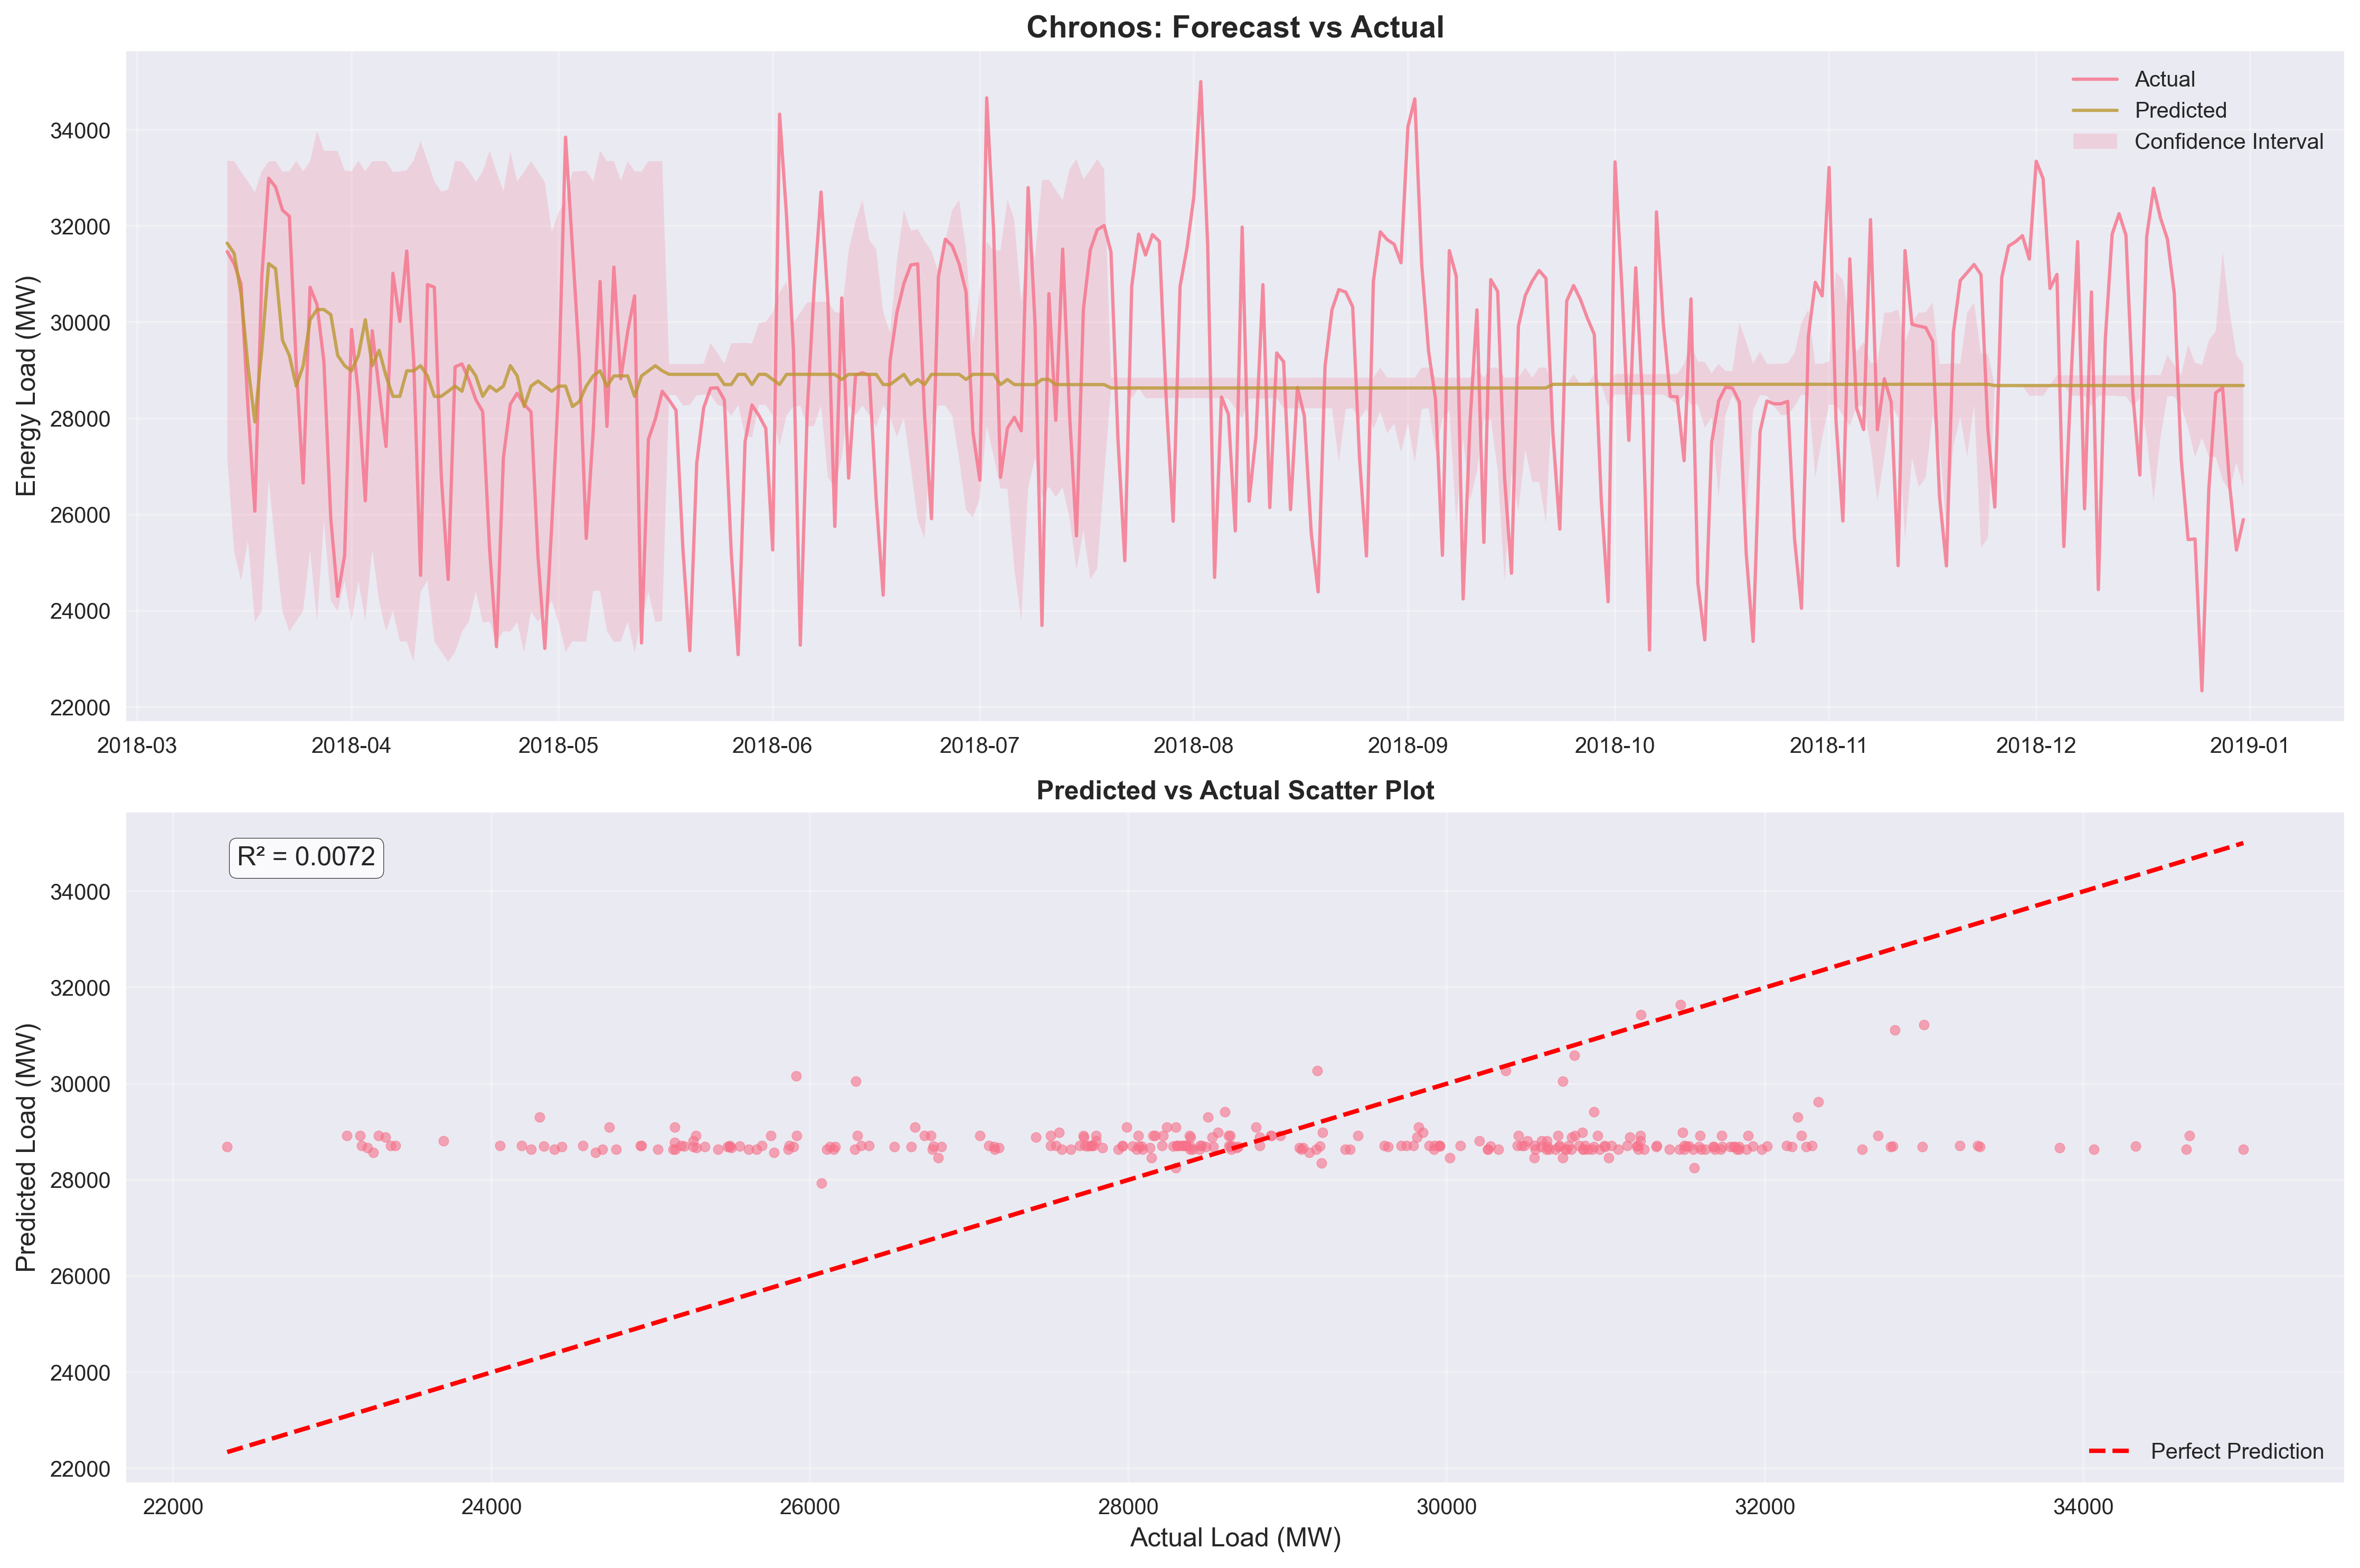

Analyzing residuals...


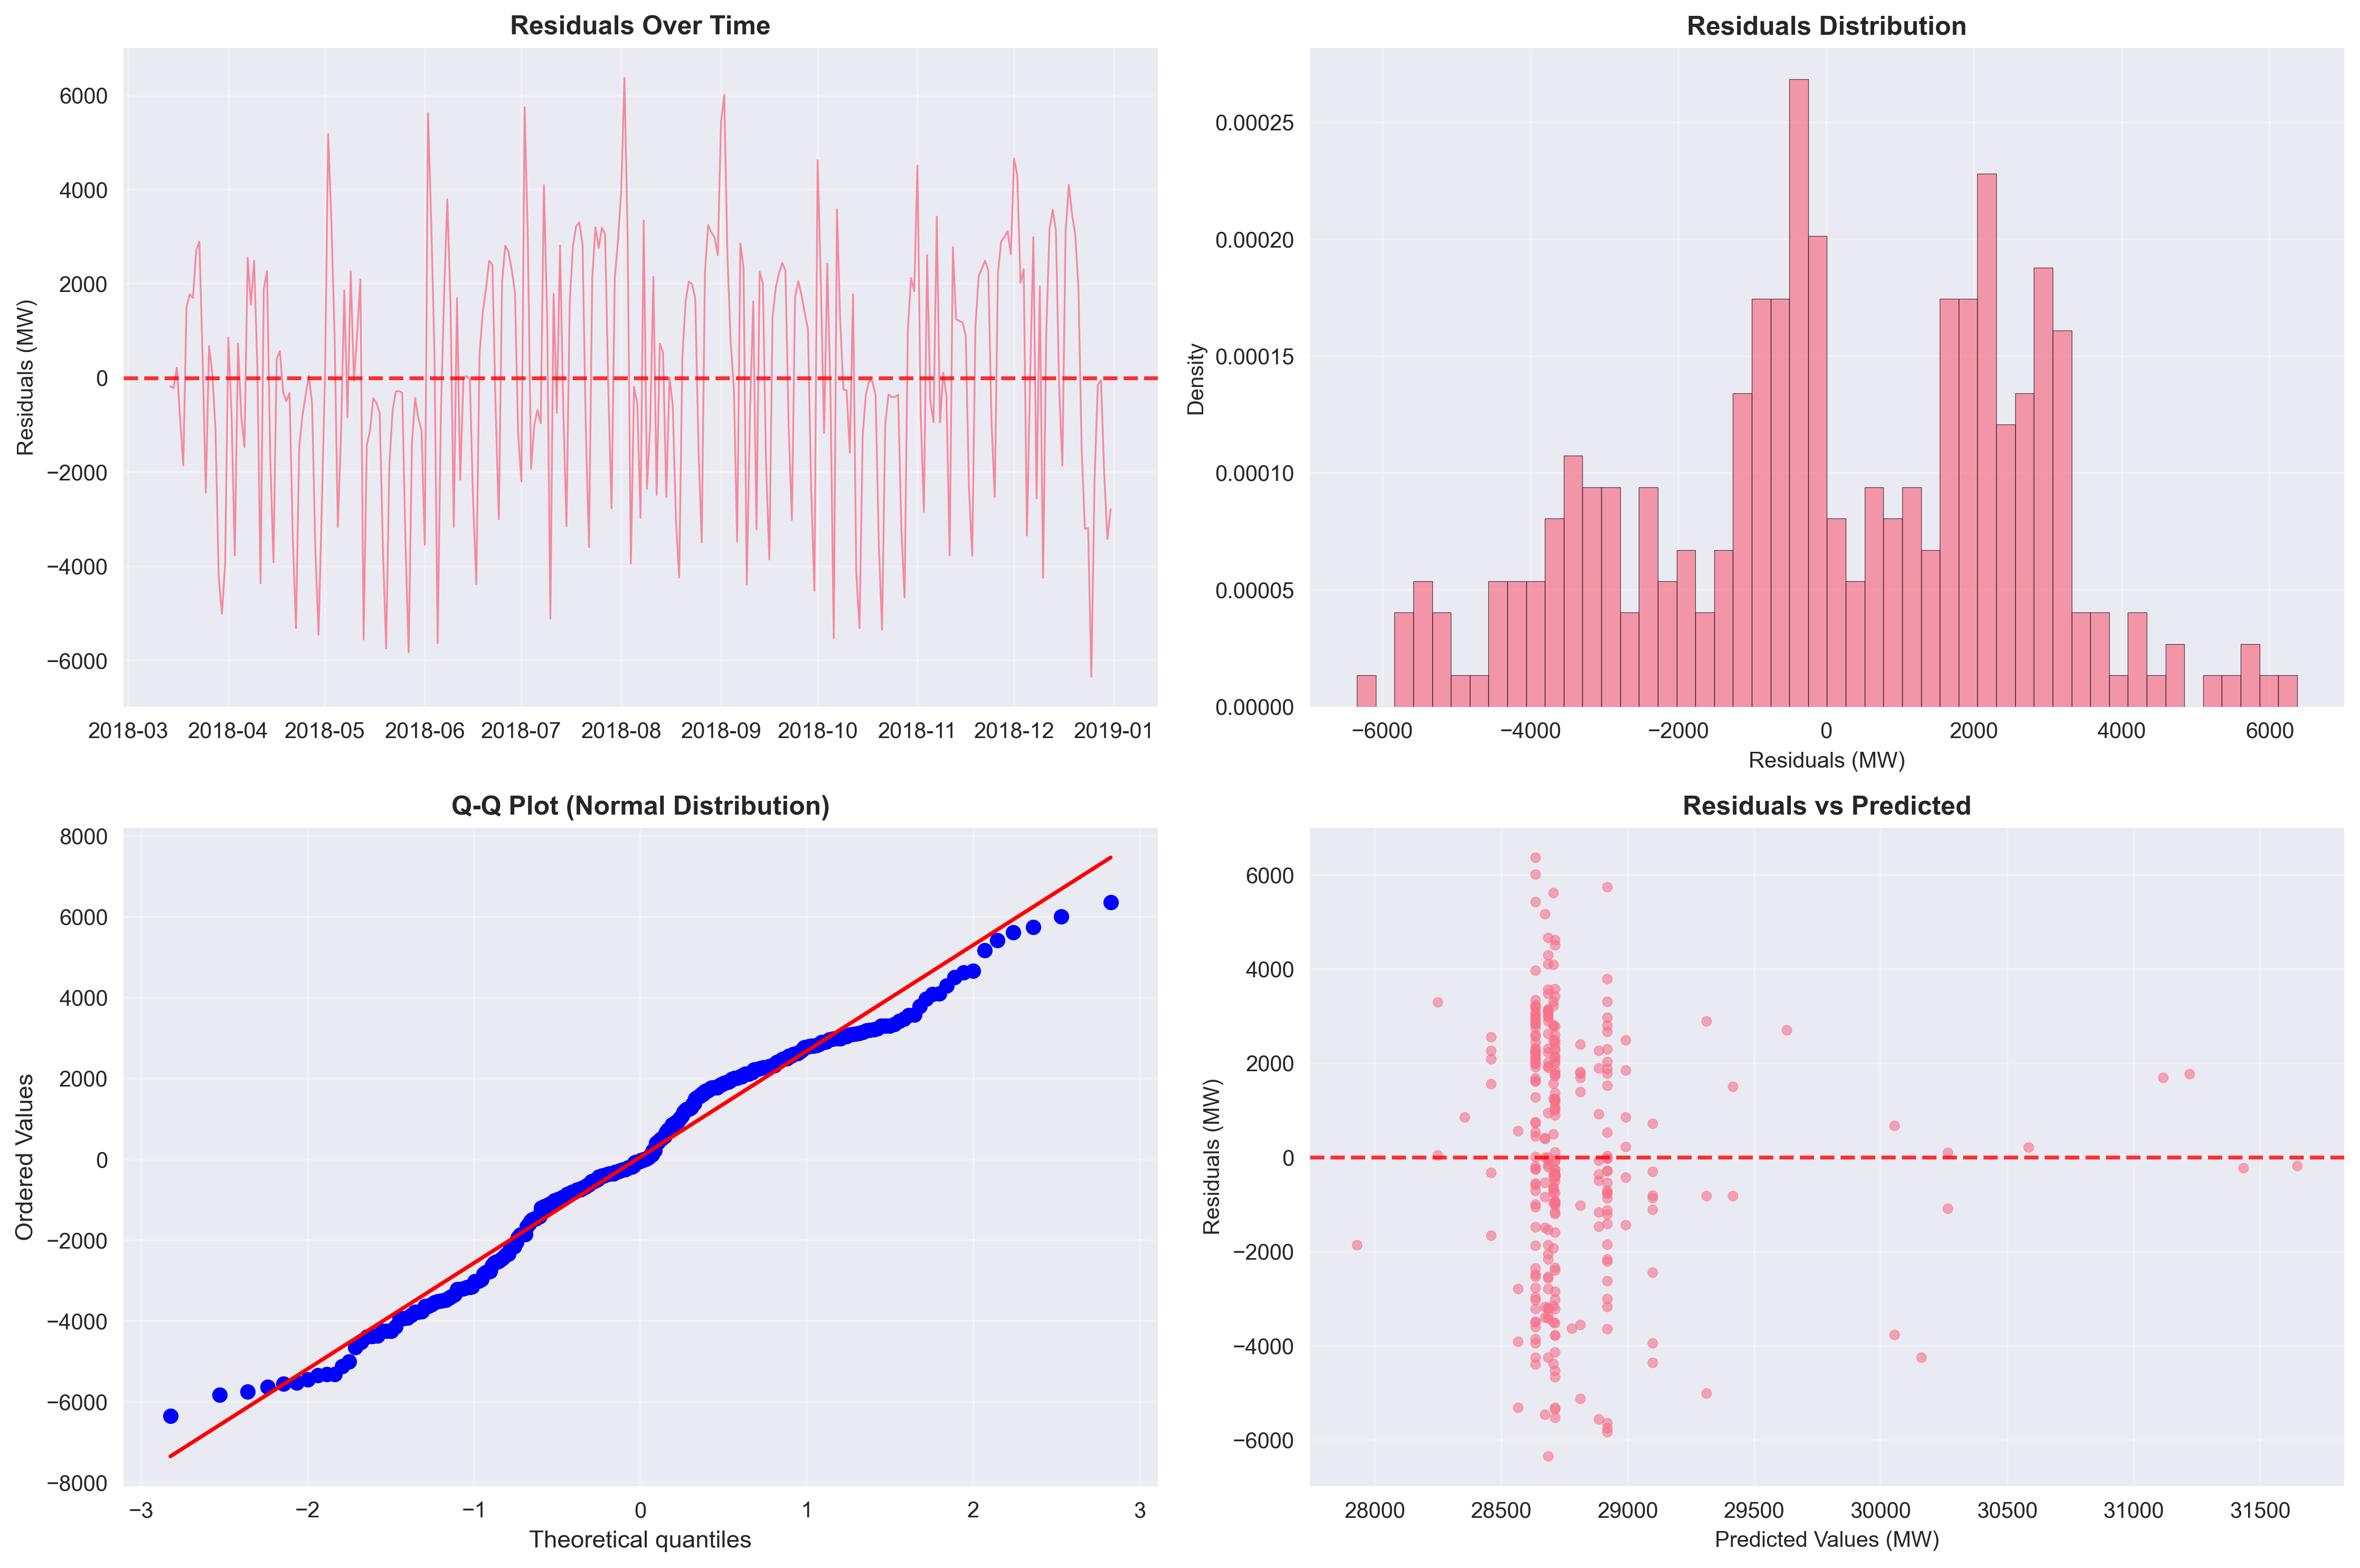

In [13]:
# Chronos forecast plot (modified visualization)
print("Generating Chronos forecast visualization...")
fig1 = visualizer.plot_chronos_forecast(forecast, test_df, train_df)  # New method
plt.show()

# Forecast vs Actual comparison (same as Prophet)
print("Comparing forecast vs actual values...")
fig2 = visualizer.plot_forecast_vs_actual(
    y_true, y_pred,
    dates=test_df['ds'],
    confidence_intervals=(forecast['yhat_lower'].values, forecast['yhat_upper'].values),
    title="Chronos: Forecast vs Actual"
)
plt.show()

# Residuals analysis (same as Prophet)
print("Analyzing residuals...")
fig3 = visualizer.plot_residuals_analysis(
    y_true, y_pred,
    dates=test_df['ds']
)
plt.show()

In [14]:


# Feature importance (not applicable for Chronos)
print("Feature importance analysis...")
importance_df = chronos_model.get_feature_importance()
if importance_df.empty:
    print("Note: Chronos is a univariate model and doesn't provide feature importance")
else:
    print("Feature Importance:")
    print(importance_df.head(10))

Feature importance analysis...
Note: Chronos doesn't provide feature importance analysis
Note: Chronos is a univariate model and doesn't provide feature importance


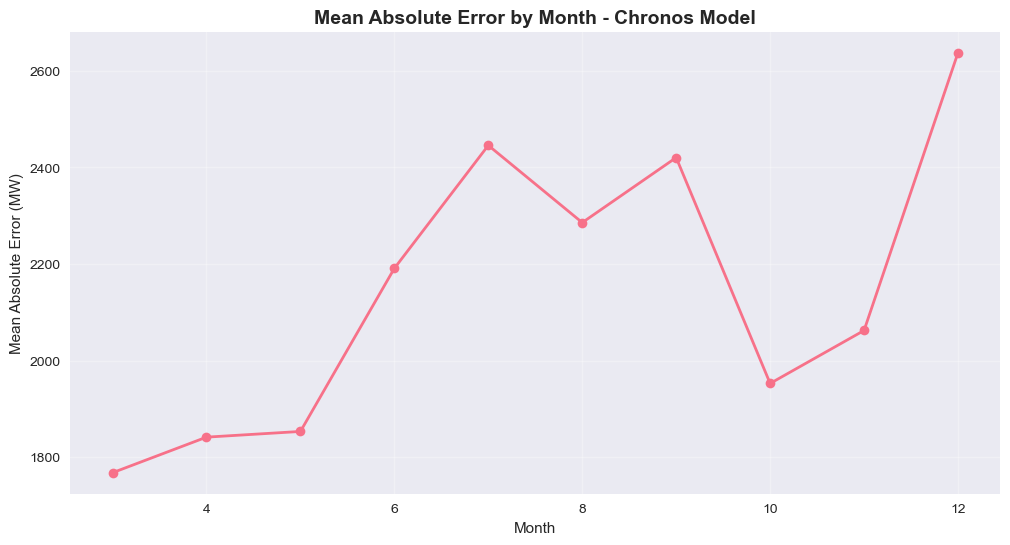

In [15]:


# Monthly error analysis (same as Prophet)
results_df = pd.DataFrame({
    'ds': test_df['ds'],
    'y_true': y_true,
    'y_pred': y_pred
})

# Ensure datetime
results_df['ds'] = pd.to_datetime(results_df['ds'])

# Calculate error
results_df['error'] = np.abs(results_df['y_true'] - results_df['y_pred'])

# Extract month
results_df['month'] = results_df['ds'].dt.month

# Group by month
monthly_error = results_df.groupby('month')['error'].mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_error.index, monthly_error.values, marker='o', linewidth=2)
plt.title('Mean Absolute Error by Month - Chronos Model', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Mean Absolute Error (MW)')
plt.grid(True, alpha=0.3)
plt.show()


In [17]:
# Summary insights (adapted for Chronos)
print("MODEL INSIGHTS & CONCLUSIONS")
print("="*50)

print(f"\nPerformance Summary:")
print(f"  • MAPE: {chronos_metrics['MAPE']:.2f}% (Target: <5% excellent, <10% good)")
print(f"  • R²: {chronos_metrics['R2']:.4f} (Explains {chronos_metrics['R2']*100:.1f}% of variance)")
print(f"  • RMSE: {chronos_metrics['RMSE']:.0f} MW (±{chronos_metrics['RMSE']/df_energy[target_col].mean()*100:.1f}% of mean load)")

print(f"\nKey Findings:")
print(f"  • Chronos model captures temporal patterns using foundation model approach")
print(f"  • Pre-trained on diverse time series, generalizes well to energy data")
print(f"  • Univariate approach focuses purely on historical patterns")
print(f"  • No external regressors needed - model learns complex seasonalities")

print(f"\nModel Characteristics:")
print(f"  • Foundation model: {config['chronos']['model_name']}")
print(f"  • Context length: {chronos_model.context_length} time steps")
print(f"  • Zero-shot forecasting capability")
print(f"  • Uncertainty quantification through sampling")

# Performance assessment (same logic as Prophet)
mape = chronos_metrics['MAPE']
if mape < 5:
    performance = "EXCELLENT"
elif mape < 10:
    performance = "GOOD"
elif mape < 20:
    performance = "FAIR"
else:
    performance = "NEEDS IMPROVEMENT"

print(f"\nOverall Performance Rating: {performance}")

MODEL INSIGHTS & CONCLUSIONS

Performance Summary:
  • MAPE: 7.67% (Target: <5% excellent, <10% good)
  • R²: 0.0072 (Explains 0.7% of variance)
  • RMSE: 2627 MW (±9.2% of mean load)

Key Findings:
  • Chronos model captures temporal patterns using foundation model approach
  • Pre-trained on diverse time series, generalizes well to energy data
  • Univariate approach focuses purely on historical patterns
  • No external regressors needed - model learns complex seasonalities

Model Characteristics:
  • Foundation model: amazon/chronos-t5-small
  • Context length: 512 time steps
  • Zero-shot forecasting capability
  • Uncertainty quantification through sampling

Overall Performance Rating: GOOD


In [18]:
# Save model and results (same structure as Prophet)
import os
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/data', exist_ok=True)

# Save model
chronos_model.save_model('../results/models/chronos_model.pkl')

# Save predictions
forecast.to_csv('../results/data/chronos_forecast.csv', index=False)
results_df.to_csv('../results/data/chronos_results.csv', index=False)

# Save metrics
metrics_df.to_csv('../results/data/chronos_metrics.csv', index=False)

print("Results saved successfully!")
print("Model: ../results/models/chronos_model.pkl")
print("Forecast: ../results/data/chronos_forecast.csv")
print("Metrics: ../results/data/chronos_metrics.csv")

Model state saved to ../results/models/chronos_model.pkl
Results saved successfully!
Model: ../results/models/chronos_model.pkl
Forecast: ../results/data/chronos_forecast.csv
Metrics: ../results/data/chronos_metrics.csv
